In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from skimage import io, transform

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler
import time
import copy

### Dataset creation

In [2]:
subset = 'train'
resized = 'resized2'

folder = ".."+os.sep+"data"+os.sep
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep

#Create mapping for labels
df = pd.read_csv(folder + file)
classes = df.classid.unique()
classes.sort()
classes_map = { classes[i]:i for i in range(len(classes)) }

In [3]:
# Plot image for testing
def show_image(image, label):
    plt.imshow(image)
    plt.title(label)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
# Dataset Class
class PlantsDataset(Dataset):
    """Plants dataset."""

    def __init__(self, csv_file, root_dir, classes, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes_map = classes

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.df.iloc[idx, 1]))
        image = io.imread(img_name + '.jpg')
        label = self.df.iloc[idx, 4]
        sample = {'image': image, 'label': classes_map[label]}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

0 (280, 280, 3) 17


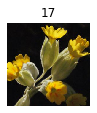

1 (280, 280, 3) 45


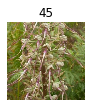

2 (280, 280, 3) 35


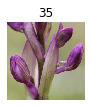

3 (280, 280, 3) 24


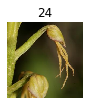

In [5]:
# Just testing if my dataset works
plants_dataset = PlantsDataset(csv_file=folder + file,
                                    root_dir=image_path, classes=classes_map)

fig = plt.figure()

for i in range(len(plants_dataset)):
    sample = plants_dataset[i]
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_image(**sample)

    if i == 3:
        plt.show()
        break

### Neural Network

In [6]:
resized = 'resized2'
folder = ".."+os.sep+"data"+os.sep

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Training Data
subset = 'train'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
trainset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

#Validation Data
subset = 'validation'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
valset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,shuffle=False, num_workers=0)

#Test Data
subset = 'test'
file =  subset + os.sep + subset + ".csv"
image_path = ".."+os.sep+"data"+os.sep+resized+os.sep+subset+os.sep
testset = PlantsDataset(csv_file=folder + file, root_dir=image_path, classes=classes_map, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=0)

image_datasets = { 'train' : trainset, 'val' : valset, 'test' : testset }
dataloaders = { 'train' : trainloader, 'val' : valloader, 'test' : testloader}
dataset_sizes = { 'train' : len(trainset), 'val' : len(valset), 'test' : len(testset) }

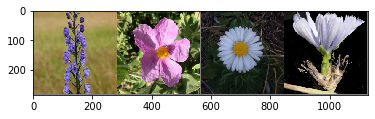

   39    12     2     6


In [7]:
# Show 4 random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
batch = dataiter.next()
images, labels = batch['image'], batch['label']

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].data.numpy() for j in range(4)))

In [8]:
# Neural Network Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 25, 5)
        self.fc1 = nn.Linear(25 * 67 * 67, 640)
        self.fc2 = nn.Linear(640, 256)
        self.fc3 = nn.Linear(256, 50)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 25 * 67 * 67)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase], 0):
                inputs, labels = data['image'].to(device), data['label'].to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, data in enumerate(dataloaders['val']):
            inputs = data['image'].to(device)
            labels = data['label'].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, truth: {}'.format(preds[j],labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
# Optmization
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [12]:
# Use the GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 25, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=112225, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=50, bias=True)
)

In [13]:
net = train_model(net, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 3.7663 Acc: 0.0571
val Loss: 3.3759 Acc: 0.0964

Epoch 1/9
----------
train Loss: 3.1521 Acc: 0.1545
val Loss: 2.9060 Acc: 0.1799

Epoch 2/9
----------
train Loss: 2.6716 Acc: 0.2366
val Loss: 2.6814 Acc: 0.2216

Epoch 3/9
----------
train Loss: 2.2480 Acc: 0.3417
val Loss: 2.3818 Acc: 0.3281

Epoch 4/9
----------
train Loss: 1.8049 Acc: 0.4525
val Loss: 2.7083 Acc: 0.3223

Epoch 5/9
----------
train Loss: 1.4163 Acc: 0.5561
val Loss: 2.7347 Acc: 0.3381

Epoch 6/9
----------
train Loss: 0.9306 Acc: 0.7236
val Loss: 3.5155 Acc: 0.2921

Epoch 7/9
----------
train Loss: 0.6845 Acc: 0.7956
val Loss: 3.0098 Acc: 0.3036

Epoch 8/9
----------
train Loss: 0.4829 Acc: 0.8637
val Loss: 3.5500 Acc: 0.2892

Epoch 9/9
----------
train Loss: 0.4402 Acc: 0.8887
val Loss: 3.5165 Acc: 0.3137

Training complete in 4m 49s
Best val Acc: 0.338129


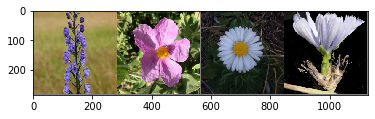

GroundTruth:  tensor(39) tensor(12) tensor(2) tensor(6)


In [14]:
dataiter = iter(testloader)
batch = dataiter.next()
images, labels = batch['image'], batch['label']

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

In [15]:
outputs = net(images.to(device))

In [16]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(4)))

Predicted:  tensor(39, device='cuda:0') tensor(40, device='cuda:0') tensor(10, device='cuda:0') tensor(0, device='cuda:0')


In [17]:
def get_accuracy(net, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 695 test images: %d %%' % (100 * correct / total))

In [18]:
get_accuracy(net, testloader)

Accuracy of the network on the 695 test images: 29 %
